# TensorFlow 2.0: Tutorial 2 Basic Classification

### Imports

In [1]:
import logging

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import plotly.figure_factory as ff
from plotly.offline import iplot
import tensorflow as tf

### Format Notebook

In [2]:
logging.basicConfig(level=logging.INFO)

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

from IPython.display import display

axis_font = {
    'color': 'gray',
    'family': 'Arial, sans-serif',
    'size': 18,
}

tick_font = {
    'color': 'black',
    'family': 'Old Standard TT, serif',
    'size': 14,
}

# Load Data

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


### Classes

| Label | Class |
|---|---|
| 0 | T-shirt/Top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat | 
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle Boot |

In [4]:
classes = [
    't-shirt_top',
    'trouser',
    'pullover',
    'dress',
    'coat',
    'sandal',
    'shirt',
    'sneaker',
    'bag',
    'ankle_boot',
]
classes_idx = {k: v for k, v in enumerate(classes)}

### Normalize Inputs with Min-Max Scaling
inputs $\in$ {0, 1}

In [5]:
x_train, x_test = [x / x.max() for x in (x_train, x_test)]
print(f'Train Shape: {x_train.shape}')
print(f'Test Shape: {x_test.shape}')

Train Shape: (60000, 28, 28)
Test Shape: (10000, 28, 28)


# Visualize Training Dataset

### First Example

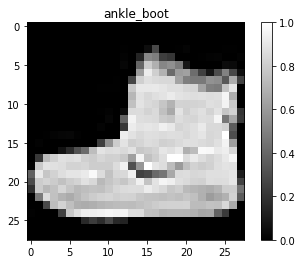

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
image = ax.imshow(x_train[0], cmap='gray')
ax.set_title(classes_idx[y_train[0]])
fig.colorbar(image, ax=ax)
plt.show()

### First 10 Examples

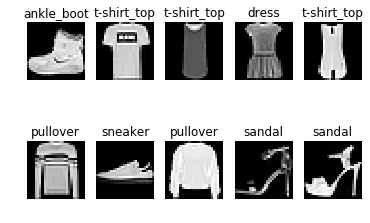

In [7]:
for n in range(10):
    ax = plt.subplot(2, 5, n + 1)
    ax.imshow(x_train[n], cmap='gray')
    ax.set_title(classes_idx[y_train[n]])
    ax.axis('off')

# Karas Model

### Create Model

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train and Evaluate Model

In [9]:
model.fit(x_train, y_train, epochs=5)
loss, accuracy = model.evaluate(x_test, y_test)
print(f'{"Model Loss:":16}{loss:.3}')
print(f'{"Model Accuracy:":16}{accuracy:.1%}')

Epoch 1/5
60000/60000 [==============================] - 5s 86us/sample - loss: 0.4977 - accuracy: 0.8253
Epoch 2/5
60000/60000 [==============================] - 5s 82us/sample - loss: 0.3760 - accuracy: 0.8651
Epoch 3/5
60000/60000 [==============================] - 5s 77us/sample - loss: 0.3398 - accuracy: 0.8757
Epoch 4/5
60000/60000 [==============================] - 5s 78us/sample - loss: 0.3155 - accuracy: 0.8843
Epoch 5/5
10000/10000 [==============================] - 0s 44us/sample - loss: 0.3471 - accuracy: 0.8715
Model Loss:     0.347
Model Accuracy: 87.2%


#### Model achieved 88% accuracy after 5 epochs.

### Model Predictions

In [10]:
predict_arr = model.predict(x_test)
predict = np.argmax(predict_arr, axis=1)

### Visualize Predictions

In [11]:
def plot_predictions(n_examples: int, predictions: np.array,
                     ground_truth: np.array):
    """
    Chart of predicted classes for a given example.
    
    :param n_examples: number of training examples to display
    :param predictions: predicted class probablilities for each example
    :param ground_truth: actual classes
    """
    cols = 2
    rows = int(np.ceil(n_examples / cols))
    fig = plt.figure(figsize=(8 * cols, 4 * rows))
    outer = gridspec.GridSpec(rows, cols, wspace=0.4, hspace=0.4)
    
    for n in range(n_examples):
        prediction = np.argmax(predictions[n])
        truth = ground_truth[n]
        
        inner = gridspec.GridSpecFromSubplotSpec(
            1, 2, subplot_spec=outer[n], wspace=0.1, hspace=0.1)
        
        # Image
        ax = plt.Subplot(fig, inner[0])
        ax.imshow(x_train[n], cmap='gray')
        title = f'{classes_idx[prediction]} {predictions[n].max():.0%}'
        if prediction == truth:
            color = 'blue'
        else:
            color = 'red'
            title = title + f'\nActual: {classes_idx[truth]}'
        color = 'blue' if prediction == truth else 'red'
        ax.set_title(title, fontsize=20, color=color)
        ax.axis('off')
        fig.add_subplot(ax)
        
        # Predictions
        ax = plt.Subplot(fig, inner[1])        
        bar = ax.bar(range(10), predictions[n], color='grey')
        bar[prediction].set_color('red')
        bar[truth].set_color('blue')
        ax.set_title(f'Example: {n}', fontsize=20, color=color)
        ax.axis('off')
        ax.set_ylim([0, 1])
        fig.add_subplot(ax)
            
    fig.show()

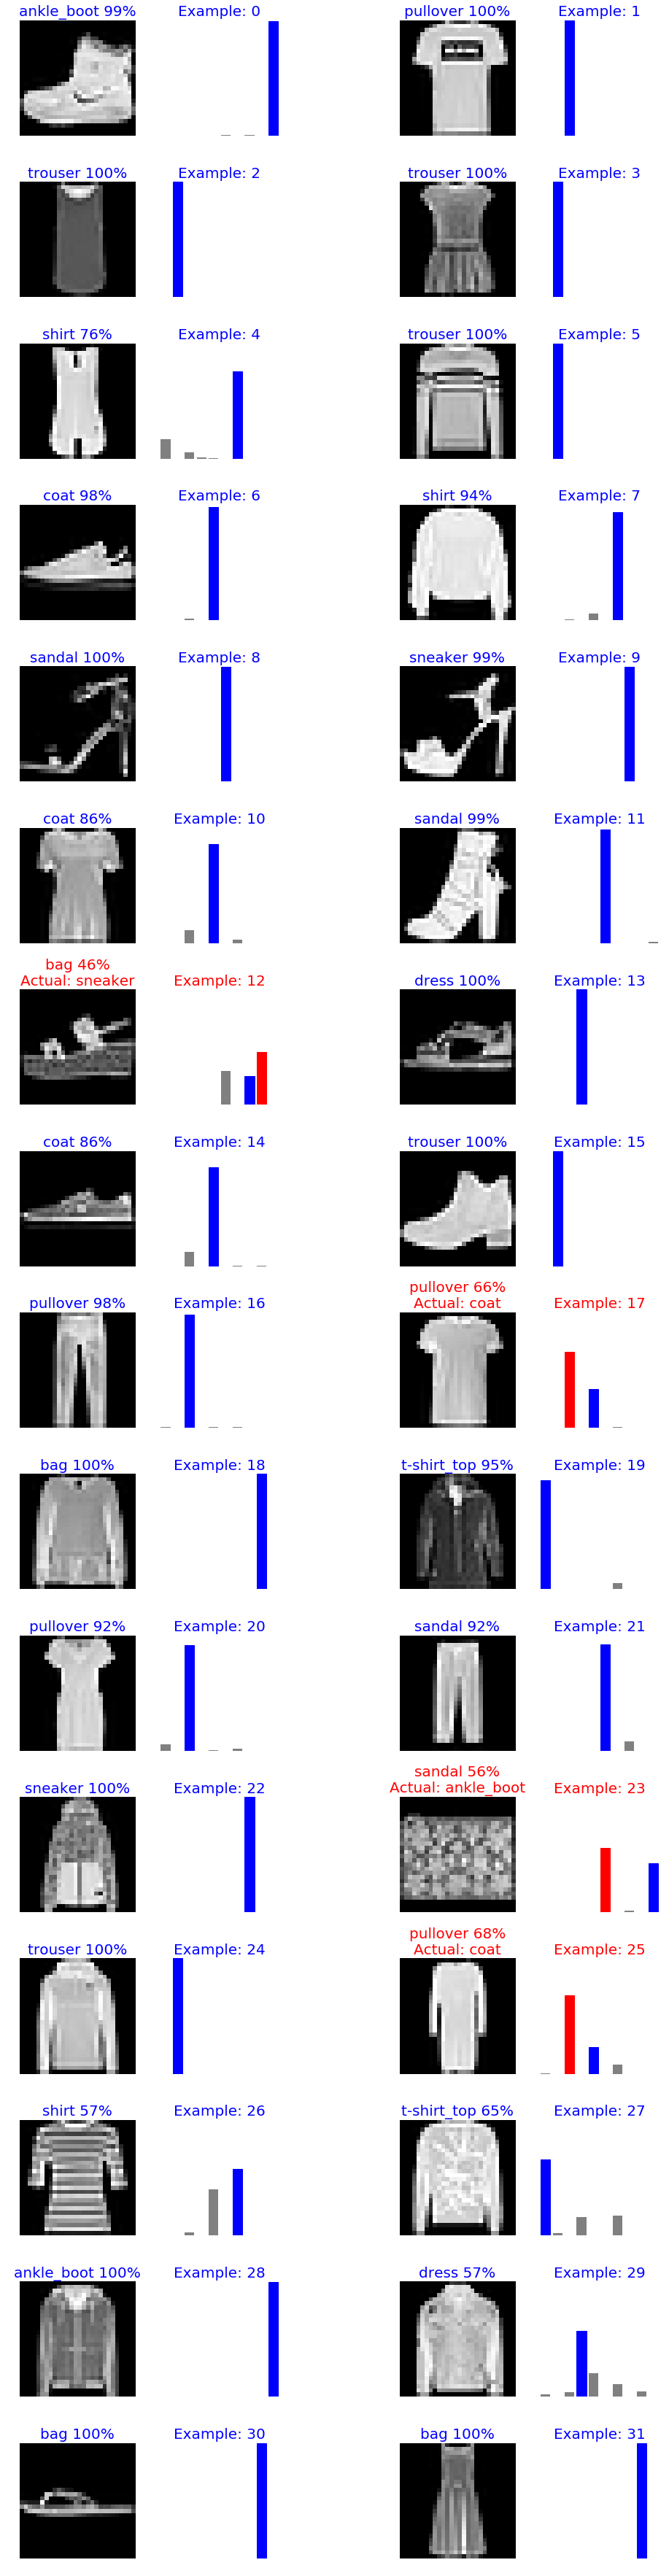

In [12]:
plot_predictions(32, predict_arr, y_test)

It appears some of the label's ground truth values are mislabeled.
- Example: 23 looks like a *bag* but is labeled an *ankle boot*
- Example: 29 looks like a *pullover* or *coat* but is labeled *dress*
- ...

### Confusion Matrix

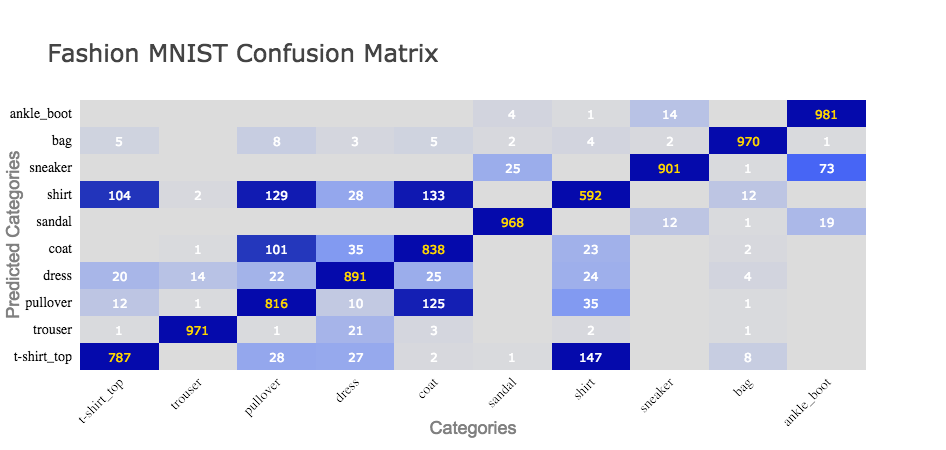

In [14]:
predict = np.argmax(model.predict(x_test), axis=1)
confusion = tf.math.confusion_matrix(y_test, predict)

zero_diag = np.copy(confusion.numpy())
np.fill_diagonal(zero_diag, 0)
max_error = zero_diag.max()

fig = ff.create_annotated_heatmap(
    z=confusion.numpy(),
    x=classes,
    y=classes,
    colorscale='Blues',
    reversescale=True,
    zmin=0,
    zmax=max_error,
    annotation_text=[['' if x == 0 else x for x in row]
                     for row in confusion.numpy().tolist()],
    font_colors=['white', 'gold'],
)
fig.layout.update({
    'title': {
        'text': 'Fashion MNIST Confusion Matrix',
        'x': 0.05,
        'y': 0.90,
    },
    'titlefont': {
            'size': 24
    },
    'xaxis': {
        'side': 'bottom',
        'tickangle': -45,
        'tickfont': tick_font,
        'title': 'Categories',
        'titlefont': axis_font,
    },
    'yaxis': {
        'tickangle': 0,
        'tickfont': tick_font,
        'title': 'Predicted Categories',
        'titlefont': axis_font,
    },
})
iplot(fig, 'MNIST Confusion Matrix')